In [1]:
#These are the normal imports I use, not all of them are used.
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import sample
import glob
import statsmodels.api as sm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture
import matplotlib.cm as cm
from scipy import stats
import datetime
import timeit
import GPy
from scipy.stats import zscore
from sklearn.decomposition import PCA
import plotly.offline as py
import six


In [24]:
data = pd.read_csv("data3.csv")
paths = pd.read_csv("paths.csv")
path_times = pd.read_csv("path_times.csv")
airports = pd.read_csv("airports_latlong.csv")
paths = paths.iloc[:,1:]

In [25]:
paths.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62
0,32.895951,-97.037200,38.805806,-104.700250,32.895951,-97.037200,38.174389,-85.736000,32.895951,-97.037200,...,32.895951,-97.037200,33.640444,-84.426944,32.895951,-97.037200,38.805806,-104.700250,32.895951,-97.0372
1,32.895951,-97.037200,33.640444,-84.426944,32.895951,-97.037200,33.640444,-84.426944,32.895951,-97.037200,...,33.942536,-118.408074,39.642568,-106.917695,32.895951,-97.037200,33.640444,-84.426944,32.895951,-97.0372
2,25.793250,-80.290556,33.640444,-84.426944,32.895951,-97.037200,33.640444,-84.426944,25.793250,-80.290556,...,25.793250,-80.290556,33.640444,-84.426944,32.895951,-97.037200,39.642568,-106.917695,32.895951,-97.0372
3,32.895951,-97.037200,41.979595,-87.904464,39.642568,-106.917695,41.979595,-87.904464,32.895951,-97.037200,...,32.895951,-97.037200,41.979595,-87.904464,39.642568,-106.917695,41.979595,-87.904464,32.895951,-97.0372
4,25.793250,-80.290556,33.640444,-84.426944,25.793250,-80.290556,38.944532,-77.455810,25.793250,-80.290556,...,39.642568,-106.917695,41.979595,-87.904464,32.895951,-97.037200,33.640444,-84.426944,32.895951,-97.0372


In [26]:
paths_std = (paths - paths.mean())/paths.std()

In [27]:
pca = PCA(n_components=30)
pca.fit(paths_std)

PCA(copy=True, n_components=30, whiten=False)

In [28]:
sum(pca.explained_variance_ratio_)

0.80344934588712125

In [29]:
x_lowdim = paths.values.dot(pca.components_.T)

In [30]:
x_lowdim.shape

(14288, 30)

In [31]:
x_lowdim[0:2,:]

array([[ -4.79132839e+02,   2.86126629e+02,  -1.36343956e+01,
         -1.15951398e+01,   5.09127903e+00,   1.48646931e+01,
         -3.19097625e+00,   3.49982089e+00,  -2.35288396e+00,
         -6.41472956e+00,   4.20020390e+00,   6.33313242e+00,
         -4.01741814e+00,   4.09296252e+00,   1.28322540e+01,
          5.34951410e+00,  -3.06880425e+00,  -9.56273366e-01,
          3.37652746e+00,   4.68396504e+00,   1.47419152e+00,
         -2.33657952e-01,  -2.03570817e+00,   2.51264120e-01,
          2.94519961e+00,   5.11441280e-01,  -3.55460966e+00,
          6.42629585e-02,   1.03536578e+00,   6.71561026e+00],
       [ -4.93261290e+02,   2.90429744e+02,  -1.36979277e+01,
          8.00520942e+00,   3.80270950e+00,   9.06007276e+00,
         -1.05707634e+00,   7.51715196e+00,  -1.64731654e+01,
          6.83842807e-02,  -7.74347680e-02,  -8.11892615e+00,
          2.47308323e+00,   5.57537032e-01,   8.07310876e+00,
          1.73374340e+00,   3.31110378e+00,  -2.10799944e+00,
       

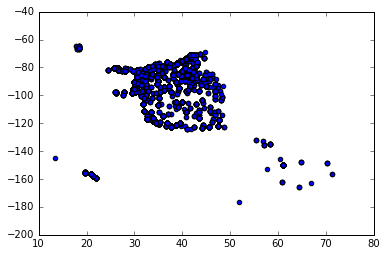

In [32]:
plt.scatter(paths.iloc[:,0],paths.iloc[:,1])

In [33]:
x_lowdim2 = (x_lowdim-x_lowdim.mean())/x_lowdim.std()
K = 10
dpgmm = mixture.GMM(n_components=K,covariance_type="full",n_iter=200)
dpgmm.fit(x_lowdim2)
z = dpgmm.predict(x_lowdim2)

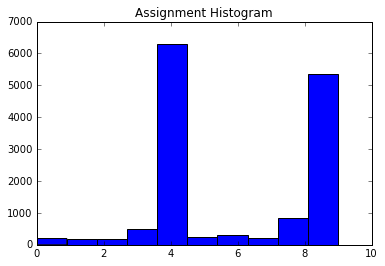

In [34]:
plt.hist(z)
plt.title("Assignment Histogram")
plt.show()

In [35]:
# pivot the table by back to lat longs
path_k_cluster=[]
for i in range(K):
    path_no = 10
    n_points = int(paths.shape[1]/2)
    if sum(z==i)==0:
        continue
    path_k = paths[z==i]
    path_k_subset = path_k.iloc[np.random.choice(path_k.shape[0],path_no),:]

    # pd.DataFrame(columns=["z","lat","long"])
    path_k_stacked = np.empty([path_no*n_points,3])
    l = 0
    for i in range(path_no):
        for j in range(n_points):
            path_k_stacked[l,:] = [i,path_k_subset.iloc[i,(2*j)],path_k_subset.iloc[i,(2*j+1)]]
            l += 1
    
    path_k_cluster.append(path_k_stacked)


In [37]:
from matplotlib import colors
colors = list(six.iteritems(colors.cnames))
colors[1][0]

'blanchedalmond'

In [52]:
#colors = cm.jet(np.linspace(0, 1, K))
#for i in range(K):
colors[3]=("red","x")
colors[4]=("black","x")

for idx in range(K):
    path_k_stacked = path_k_cluster[idx]

    airports2 = [ dict(
            type = 'scattergeo',
            locationmode = 'USA-states',
            lon = airports.long,
            lat = airports.lat,
            hoverinfo = 'text',
            text = airports.airport,
            mode = 'markers',
            marker = dict( 
                size=2, 
                color='rgb(255, 0, 0)',
                line = dict(
                    width=3,
                    color='rgba(68, 68, 68, 0)'
                )
            ))]

    flight_paths = []
    old_point = 0
    for i in range(path_k_stacked.shape[0]-1):
        oldpoint = path_k_stacked[i,0]
        newpoint = path_k_stacked[i+1,0]
        if newpoint != oldpoint:
            col = 'rgb(243, 243, 243)'
        else:
            col = colors[idx+25][0]

        flight_paths.append(
            dict(
                type = 'scattergeo',
                locationmode = 'USA-states',
                lon = [ path_k_stacked[i,2], path_k_stacked[i+1,2]],
                lat = [ path_k_stacked[i,1], path_k_stacked[i+1,1]],
                mode = 'lines',
                line = dict(
                    width = 1,
                    color = col,
                )#,
                #opacity = float(df_flight_paths['cnt'][i])/float(df_flight_paths['cnt'].max()),
            )
        )

    layout = dict(
            title = 'Dec. 2014 Dec flight paths<br>(Hover for airport names)',
            showlegend = False, 
            geo = dict(
                scope='north america',
                projection=dict( type='azimuthal equal area' ),
                showland = True,
                landcolor = 'rgb(243, 243, 243)',
                countrycolor = 'rgb(204, 204, 204)',
            ),
        )

    fig = dict( data=airports2+flight_paths, layout=layout )
    url = py.plot( fig, filename='d3-flight-paths__'+str(idx) )

/Users/sachin/anaconda/lib/python3.5/site-packages/plotly/offline/offline.py:252: UserWarning:

Your filename `d3-flight-paths__0` didn't end with .html. Adding .html to the end of your file.

/Users/sachin/anaconda/lib/python3.5/site-packages/plotly/offline/offline.py:252: UserWarning:

Your filename `d3-flight-paths__1` didn't end with .html. Adding .html to the end of your file.

/Users/sachin/anaconda/lib/python3.5/site-packages/plotly/offline/offline.py:252: UserWarning:

Your filename `d3-flight-paths__2` didn't end with .html. Adding .html to the end of your file.

/Users/sachin/anaconda/lib/python3.5/site-packages/plotly/offline/offline.py:252: UserWarning:

Your filename `d3-flight-paths__3` didn't end with .html. Adding .html to the end of your file.

/Users/sachin/anaconda/lib/python3.5/site-packages/plotly/offline/offline.py:252: UserWarning:

Your filename `d3-flight-paths__4` didn't end with .html. Adding .html to the end of your file.

/Users/sachin/anaconda/lib/python3.

In [51]:
colors[3]

('red', 'x')